<a href="https://colab.research.google.com/github/JyothyVariyampat/Benchmark-ML-and-DL-Models-for-Small-Molecule-Immunity-Target-Bioactivity-Prediction./blob/main/GCN_Optuna_Classification_AID1259354.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 70.5 MB/s eta 0:00:00


In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.0 MB/s eta 0:00:00


In [ ]:
!pip install --quiet optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.6 MB/s eta 0:00:00


[I 2024-11-19 07:52:31,807] A new study created in memory with name: no-name-d34ae6ae-a285-40e6-a5c8-e7ac975dccfb
[I 2024-11-19 07:52:48,529] Trial 0 finished with value: 0.6013698630136987 and parameters: {'hidden_channels': 74, 'num_layers': 4, 'dropout': 0.26539013366782105, 'learning_rate': 0.00013435766196159935, 'weight_decay': 1.7515891046636287e-05}. Best is trial 0 with value: 0.6013698630136987.
[I 2024-11-19 07:52:59,009] Trial 1 finished with value: 0.6191780821917808 and parameters: {'hidden_channels': 122, 'num_layers': 2, 'dropout': 0.18213428971928836, 'learning_rate': 0.0004448337898830944, 'weight_decay': 5.98265001005497e-06}. Best is trial 1 with value: 0.6191780821917808.
[I 2024-11-19 07:53:09,523] Trial 2 finished with value: 0.6246575342465753 and parameters: {'hidden_channels': 115, 'num_layers': 2, 'dropout': 0.4869556680480187, 'learning_rate': 0.005617057684790382, 'weight_decay': 3.1030781870482935e-05}. Best is trial 2 with value: 0.6246575342465753.
[I 20

Best hyperparameters: {'hidden_channels': 94, 'num_layers': 4, 'dropout': 0.1515358203761057, 'learning_rate': 0.0033977054228689204, 'weight_decay': 1.0810414260394193e-05}
Epoch: 000, Train Loss: 0.6927, Train Accuracy: 0.5430, Test Loss: 0.6769, Test Accuracy: 0.5740, ROC AUC: 0.6445261775192344, F1: 0.6777, Kappa: 0.1479, Precision: 0.5450, Recall: 0.8959
Epoch: 001, Train Loss: 0.6754, Train Accuracy: 0.5714, Test Loss: 0.6648, Test Accuracy: 0.6041, ROC AUC: 0.6513942578344906, F1: 0.6682, Kappa: 0.2082, Precision: 0.5751, Recall: 0.7973
Epoch: 002, Train Loss: 0.6562, Train Accuracy: 0.6156, Test Loss: 0.6886, Test Accuracy: 0.5466, ROC AUC: 0.6529780446612873, F1: 0.6713, Kappa: 0.0932, Precision: 0.5265, Recall: 0.9260
Epoch: 003, Train Loss: 0.6627, Train Accuracy: 0.6036, Test Loss: 0.6526, Test Accuracy: 0.6151, ROC AUC: 0.6672321261024582, F1: 0.6025, Kappa: 0.2301, Precision: 0.6228, Recall: 0.5836
Epoch: 004, Train Loss: 0.6488, Train Accuracy: 0.6293, Test Loss: 0.6539,

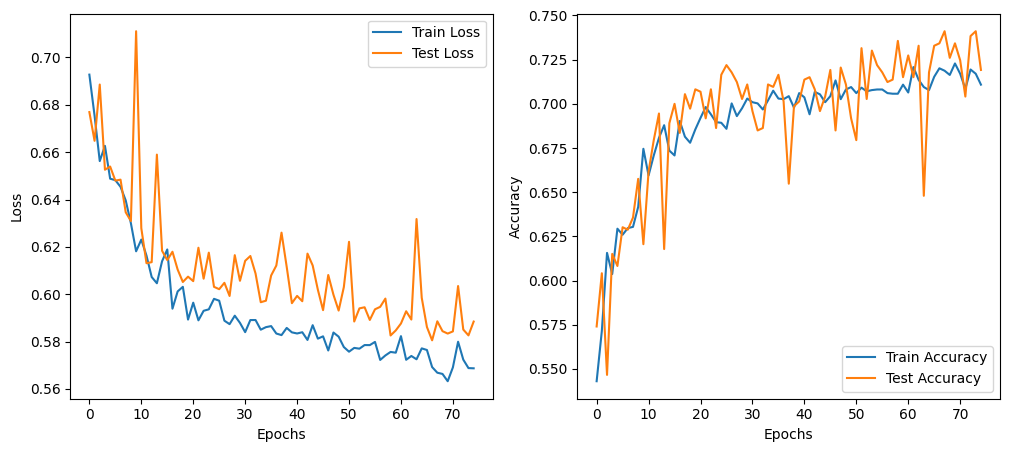

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_smiles
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import roc_auc_score, f1_score, cohen_kappa_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import optuna
import os
import random

# Set random seed for reproducibility
def seed_set(seed=50):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_set()

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your dataset
df_final = pd.read_csv('/content/AID1259354Active_Inactive_Molecules_smiles.csv')

# Preprocess data and create graph list
graph_list = []
for i, smile in enumerate(df_final['PUBCHEM_EXT_DATASOURCE_SMILES']):
    try:
        g = from_smiles(smile)
        g.x = g.x.float()
        y_value = 1.0 if df_final['PUBCHEM_ACTIVITY_OUTCOME'][i] == 'Active' else 0.0
        y = torch.tensor(y_value, dtype=torch.float).view(1, -1)
        g.y = y
        graph_list.append(g)
    except Exception as e:
        print(f"Error processing SMILES {smile}: {e}")
        continue

# Stratified split of dataset into train and test sets
labels = [g.y.item() for g in graph_list]
train_dataset, test_dataset = train_test_split(graph_list, test_size=0.2, stratify=labels, random_state=50)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout):
        super(GCN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.convs.append(GCNConv(hidden_channels, out_channels))
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        x = global_mean_pool(x, batch)
        return torch.sigmoid(x)

# Training function
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.binary_cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        pred = (out > 0.5).float()
        correct += pred.eq(data.y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# Testing function
def test(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = F.binary_cross_entropy(out, data.y)
            total_loss += loss.item() * data.num_graphs
            pred = (out > 0.5).float()
            correct += pred.eq(data.y).sum().item()

            all_preds.extend(out.cpu().numpy().flatten())
            all_labels.extend(data.y.cpu().numpy().flatten())

    loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)

    if len(np.unique(all_labels)) < 2:
        roc_auc = None
    else:
        roc_auc = roc_auc_score(all_labels, all_preds)

    f1 = f1_score(all_labels, np.round(all_preds))
    kappa = cohen_kappa_score(all_labels, np.round(all_preds))
    precision = precision_score(all_labels, np.round(all_preds))
    recall = recall_score(all_labels, np.round(all_preds))

    return loss, accuracy, roc_auc, f1, kappa, precision, recall

# Optuna objective function for hyperparameter optimization
def objective(trial):
    hidden_channels = trial.suggest_int("hidden_channels", 32, 128)
    num_layers = trial.suggest_int("num_layers", 2, 5)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    model = GCN(in_channels=9, hidden_channels=hidden_channels, out_channels=1,
                num_layers=num_layers, dropout=dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(20):
        train_loss, train_acc = train(model, train_loader, optimizer)

    test_loss, test_acc, roc_auc, f1, kappa, precision, recall = test(model, test_loader)
    return test_acc

# Run Optuna for hyperparameter optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Best hyperparameters from Optuna
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Final training with the best hyperparameters
model = GCN(in_channels=9, hidden_channels=best_params["hidden_channels"], out_channels=1,
            num_layers=best_params["num_layers"], dropout=best_params["dropout"]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params["learning_rate"],
                             weight_decay=best_params["weight_decay"])

epochs = 75
score_train_loss = []
score_train_acc = []
score_test_loss = []
score_test_acc = []
score_roc_auc = []
score_f1 = []
score_kappa = []
score_precision = []
score_recall = []

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer)
    test_loss, test_acc, roc_auc, f1, kappa, precision, recall = test(model, test_loader)

    score_train_loss.append(train_loss)
    score_train_acc.append(train_acc)
    score_test_loss.append(test_loss)
    score_test_acc.append(test_acc)
    score_roc_auc.append(roc_auc)
    score_f1.append(f1)
    score_kappa.append(kappa)
    score_precision.append(precision)
    score_recall.append(recall)

    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, '
          f'ROC AUC: {roc_auc}, F1: {f1:.4f}, Kappa: {kappa:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

# Plotting results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), score_train_loss, label='Train Loss')
plt.plot(range(epochs), score_test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), score_train_acc, label='Train Accuracy')
plt.plot(range(epochs), score_test_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
# prompt: from the above epochs calculate best score for all metrics, include train and test accuracy also

# Find the best scores for each metric across all epochs
best_train_loss = min(score_train_loss)
best_train_acc = max(score_train_acc)
best_test_loss = min(score_test_loss)
best_test_acc = max(score_test_acc)
best_roc_auc = max(score_roc_auc) if score_roc_auc[0] is not None else None  # Handle potential None values
best_f1 = max(score_f1)
best_kappa = max(score_kappa)
best_precision = max(score_precision)
best_recall = max(score_recall)

print("\nBest Scores:")
#print(f"Best Train Loss: {best_train_loss:.4f}")
print(f"Best Train Accuracy: {best_train_acc:.4f}")
#print(f"Best Test Loss: {best_test_loss:.4f}")
print(f"Best Test Accuracy: {best_test_acc:.4f}")
print(f"Best ROC AUC: {best_roc_auc}")
print(f"Best F1 Score: {best_f1:.4f}")
print(f"Best Kappa Score: {best_kappa:.4f}")
print(f"Best Precision: {best_precision:.4f}")
print(f"Best Recall: {best_recall:.4f}")


Best Scores:
Best Train Accuracy: 0.7229
Best Test Accuracy: 0.7411
Best ROC AUC: 0.7834490523550385
Best F1 Score: 0.7458
Best Kappa Score: 0.4822
Best Precision: 0.7811
Best Recall: 0.9260
